<a href="https://colab.research.google.com/github/lntelliMed/stock-prediction/blob/master/scikit_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame

import datetime
import math

import matplotlib as mpl
from matplotlib import style
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [0]:
start = datetime.datetime(2009, 1, 1)
end = datetime.datetime.now()

df = web.DataReader('AMZN', 'yahoo', start, end)

# df.head()
df.shape

(2687, 6)

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-08-29    1873.465400
2019-08-30    1872.869901
2019-09-03    1872.295001
2019-09-04    1871.860502
2019-09-05    1871.837101
Name: Adj Close, dtype: float64

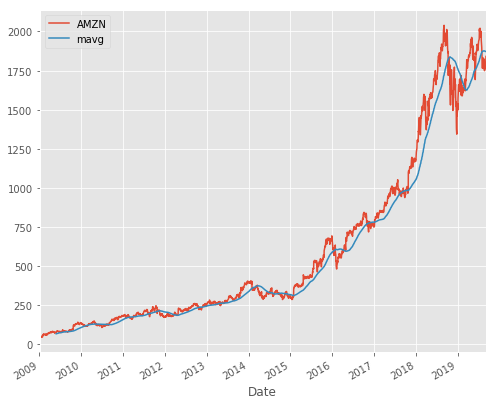

In [0]:
mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')

close_px.plot(label='AMZN')
mavg.plot(label='mavg')
plt.legend()

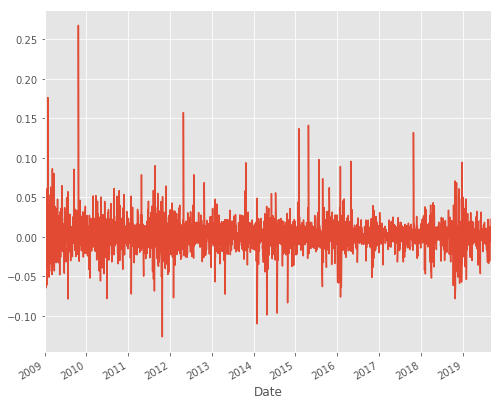

In [0]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
dfcomp = web.DataReader(['AMZN', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',
                               start=start,
                               end=end)['Adj Close']
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

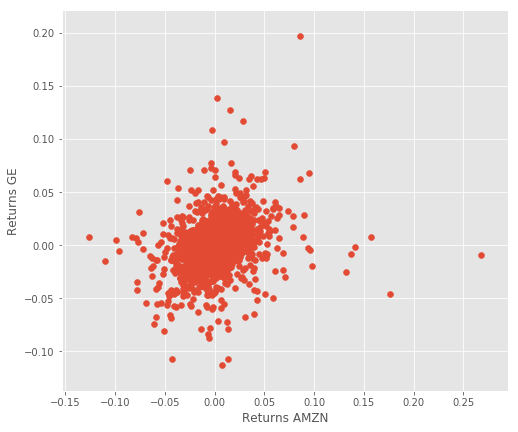

In [0]:
plt.scatter(retscomp.AMZN, retscomp.GE)
plt.xlabel('Returns AMZN')
plt.ylabel('Returns GE')

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-01-02,54.360001,7296400,6.364972,5.861738
2009-01-05,54.060001,9509800,5.012954,-2.996587
2009-01-06,57.360001,11080100,7.792889,5.151240
2009-01-07,56.200001,7942700,2.846979,-0.159887
2009-01-08,57.160000,6577900,4.793558,3.946169


In [0]:
dfreg.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(dfreg)))
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [0]:
X = preprocessing.scale(X)

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

Dimension of X (2660, 4)
Dimension of y (2660,)


In [0]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

clfknn = KNeighborsRegressor(n_neighbors=2);
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9831984102298917
The quadratic regression 2 confidence is  0.9846916311359071
The quadratic regression 3 confidence is  0.9882010944217914
The knn regression confidence is  0.9725549083349178


In [0]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencepoly3, forecast_out)

[1882.62321447 1817.49449836 1800.65839197 1802.45014622 1759.00529407
 1781.01644878 1795.48880376 1840.56943574 1840.96870165 1830.89029468
 1823.56341917 1779.08628737 1808.27926898 1837.3311522  1856.17540651
 1864.80099996 1880.68895467 1845.28734469 1763.9359824  1820.34235444
 1814.07539883 1838.79583081 1834.02771272 1820.39776128 1824.44619261
 1858.34740553 1857.64569882] 0.9882010944217914 27


In [0]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

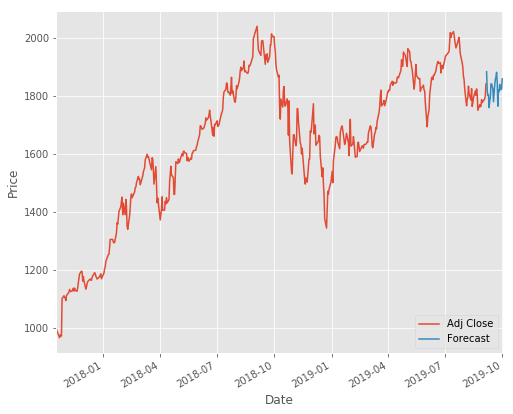

In [0]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()